# Pipiline
1. [Загрузка данных](#load)
2. [Анализ данных](#analys)
    - [retail_train](#analys_retail)
    - [product](#analys_product)
    - [hh_demographic](#analys_hh)

3. [префильтрация](#prefilter)
4. [разбиваем на трейн/тесты в соответствии с 2 уровнями](#split)
5. [обучаем рекоммендер первого уровня](#model_lvl1)
6. [формирование дата сета для обучения модели 2го уровня из кандидатов 1го уровня](#dataset_lvl2)
7. [Featers engineering](#ed_users_items)
   - [user]  
       -- [средний чек](#mean_check)  
       -- [номер недели последней покупки ](#last_week)  
       -- [количество покупок в неделю](#checks_week)   
   - [item-user]  
       -- [общее количество покупок у покупателя](#quantity_total)   
   - [item]  
       -- [Средняя стоимость товара](#mean_sv_item)  
8. [CatBoost подбор параметров grid_search и обучение на лучших](#model_lvl2)
9. [предсказание и оценка по pre_at_5](#predict)

 <a name="predict"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Модель второго уровня
from lightgbm import LGBMRanker

import os, sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

C:\Users\Svet\anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Загрузка данных <a name="load"></a>

In [2]:
data = pd.read_csv('C:/Users/Svet/gb/recomend/l2/retail_train.csv')
item_features = pd.read_csv('C:/Users/Svet/gb/recomend/l2/product.csv')
user_features = pd.read_csv('C:/Users/Svet/gb/recomend/l2/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

# Анализ данных <a name="analys"></a>

## действия покупателей retail_train <a name="analys_retail"></a>

главные данные по действиям покупателей (что купил, в какой день, в каком магазине, сколько раз, время покупки, скидка)

In [75]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


Числовые значения, пропусков нет, категориальных признаков нет. 

In [78]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


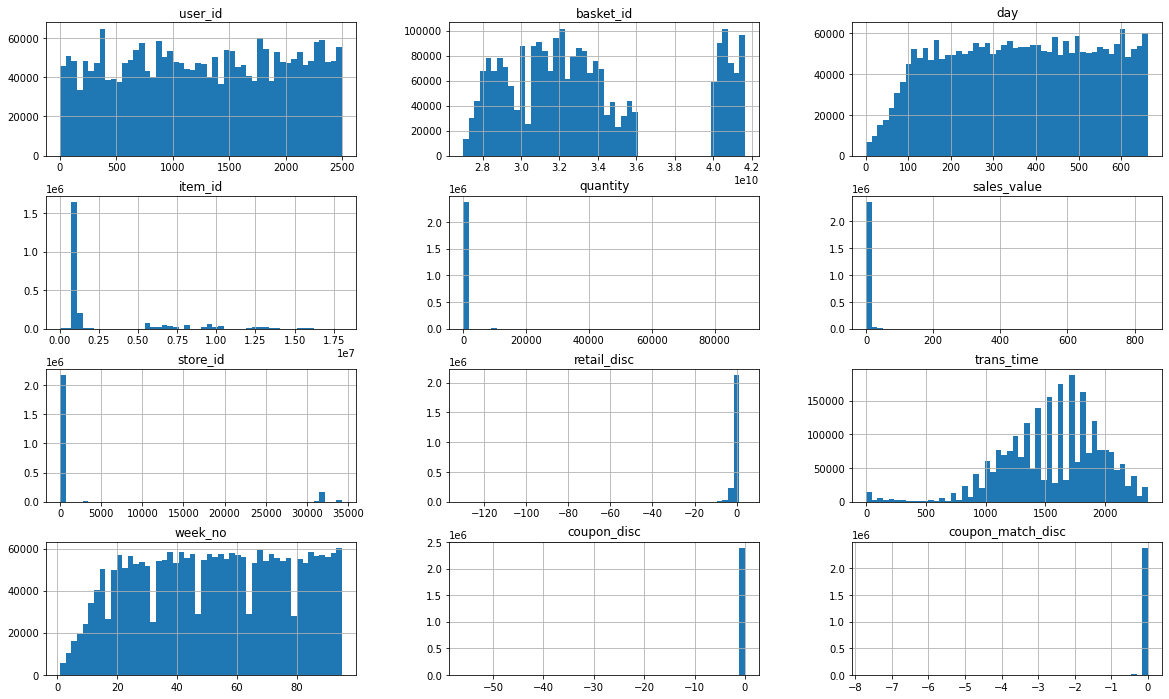

In [15]:
data.hist(figsize=(20,12), bins=50);

In [62]:
data.columns.to_list()

['user_id',
 'basket_id',
 'day',
 'item_id',
 'quantity',
 'sales_value',
 'store_id',
 'retail_disc',
 'trans_time',
 'week_no',
 'coupon_disc',
 'coupon_match_disc']

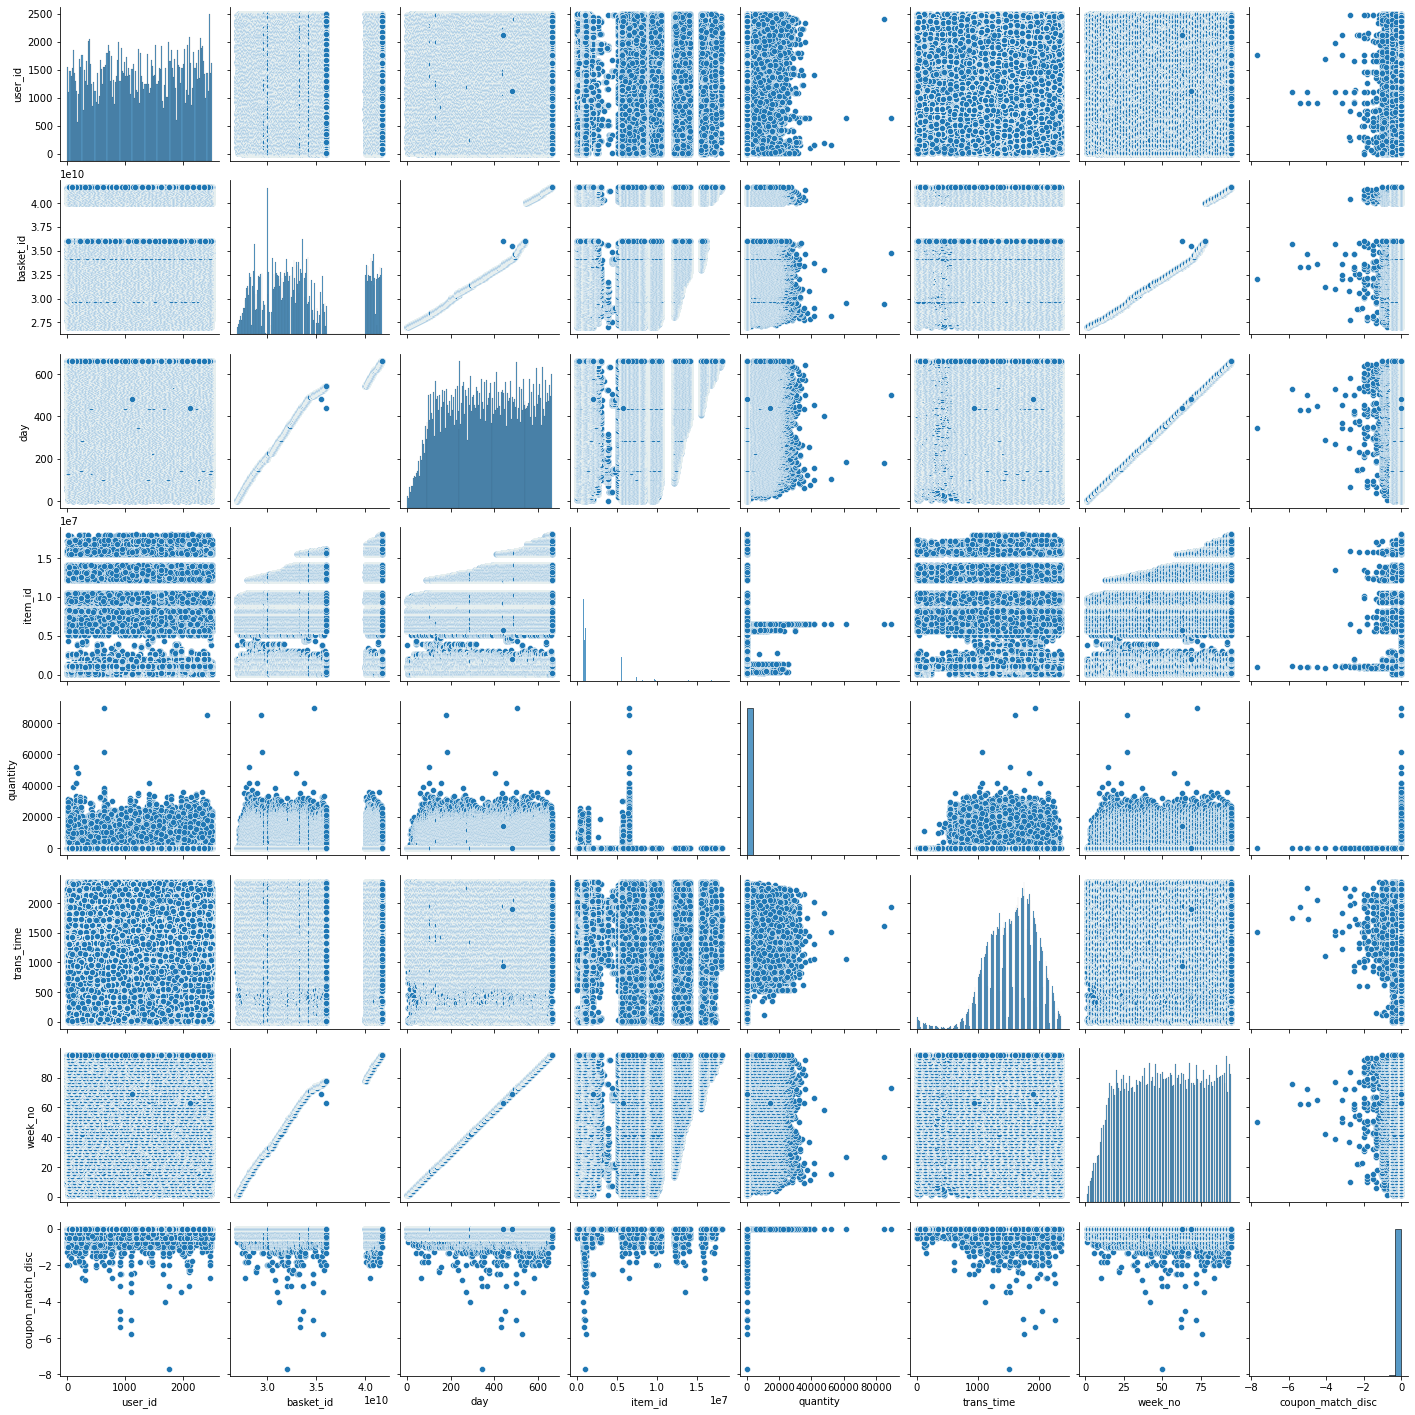

In [5]:
feats_pair = ['user_id', 'basket_id', 'day', 'item_id', 'quantity', 'trans_time', 'week_no', 'coupon_match_disc']
sns.pairplot(data[feats_pair]);

по графикам можно сделать выводы:
- есть некоторый сверх популярный товар, которые покупают почти все покупатели
- в первые дни и недели покупательская активность снижена
- есть какая-то корзина с слишком большим количеством товаров
- 

## признаки товаров product <a name="analys_product"></a>

признаки товаров (производитель, бренд, категория, подкатегория, размер(вес))

In [79]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [81]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


#### обзор категориальных признаков

In [7]:
for cat_colname in item_features.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(item_features[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

department

GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
FROZEN GROCERY        23
KIOSK-GAS             16
                      15
CHEF SHOPPE           14
RX                     9
CNTRL/STORE SUP        4
POSTAL CENTER          3
VIDEO RENTAL           3
DAIRY DELI             3
TOYS                   3
GM MERCH EXP           3
PROD-WHS SALES         2
AUTOMOTIVE             2
DELI/SNACK BAR         2
GRO BAKERY             2
PHOTO                  2
VIDEO                  2
CHARITABLE CONT        2
HBC                    1
PHARMACY SUPP

## признаки покупателей hh_demographic <a name="analys_hh"></a>
признаки покупателей: возрастная группа, материальное положение, собственность, дети

In [89]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [91]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


#### все данные категориальные

In [8]:
for cat_colname in user_features.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(user_features[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

age_desc

45-54    288
35-44    194
25-34    142
65+       72
55-64     59
19-24     46
Name: age_desc, dtype: int64
****************************************************************************************************

marital_status_code

U    344
A    340
B    117
Name: marital_status_code, dtype: int64
****************************************************************************************************

income_desc

50-74K       192
35-49K       172
75-99K        96
25-34K        77
15-24K        74
Under 15K     61
125-149K      38
100-124K      34
150-174K      30
250K+         11
175-199K      11
200-249K       5
Name: income_desc, dtype: int64
****************************************************************************************************

homeowner_desc

Homeowner          504
Unknown            233
Renter              42
Probable Renter     11
Probable Owner      11
Name: homeowner_desc, dtype: int64
**************************************************************************

In [14]:

print(f' признаки покупателей есть всего для {len(user_features.user_id.unique())/data.user_id.nunique() * 100 :.2f}% от общего числа покупателей')

 признаки покупателей есть всего для 32.05% от общего числа покупателей


# Префильтрация <a name="prefilter"></a>

In [3]:
def prefilter_items(data, item_features):
    #### 3 самых популярных товара заменяем фиктивным
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
    top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()
    data.loc[data['item_id'].isin(top_5000[:3]), 'item_id'] = 999999
    
    #### Уберем товары, которые не продавались за последние 12 месяцев (заменяем фиктивным)
    last_week = data['week_no'].values.max()
    data.loc[data['week_no'] < last_week - 53, 'item_id'] = 999999
    
    #### Уберем слишком дешевые товары (заменяем фиктивным)
    mean_price = data.groupby('item_id')['quantity', "sales_value"].sum()
    mean_price["mean_price"] = mean_price["sales_value"] / mean_price["quantity"]
    cheap_list = mean_price.loc[mean_price["mean_price"] < 0.9].index.tolist()
    data.loc[data['item_id'].isin(cheap_list), 'item_id'] = 999999
    
    #### Cамые непопулярные товары (заменяем фиктивным)
    popularity_pu = data.groupby('item_id')['user_id'].nunique().reset_index()
    popularity_pu.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    popularity_pu['share_unique_users'] = popularity_pu['share_unique_users'] / data['user_id'].nunique()
    popularity_pu.sort_values('share_unique_users', ascending=False, inplace=True)
#     popularity_pu[popularity_pu['share_unique_users'] < 0.005]
    unpop_list = popularity_pu[popularity_pu['share_unique_users'] < 0.005].item_id.tolist()
    data.loc[data['item_id'].isin(unpop_list), 'item_id'] = 999999
    
    #### Неинтересные категории рецепрутные лекарства и все, что менее 5 товаров в категории
    dep_list = ['RX', 'CNTRL/STORE SUP', 'POSTAL CENTER', 'VIDEO RENTAL', 'DAIRY DELI', 'TOYS', 
                'GM MERCH EXP', 'PROD-WHS SALES', 'AUTOMOTIVE', 'DELI/SNACK BAR', 'GRO BAKERY',
                'PHOTO', 'VIDEO', 'CHARITABLE CONT', 'HBC', 'PHARMACY SUPPLY', 'PORK', 'MEAT-WHSE',
                'HOUSEWARES', 'ELECT &PLUMBING']
    
    for dep in dep_list:
        drop_items_list = item_features.loc[item_features['department'] == dep, "item_id"].values
        data.loc[data['item_id'].isin(drop_items_list), 'item_id'] = 999999
    
    return data

In [4]:
data = prefilter_items(data, item_features)

## Разбиение данных <a name="split"></a>

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

## обучаем рекоммендер первого уровня  <a name="model_lvl1"></a>

In [6]:
recommender = MainRecommender(data_train_lvl_1)#, item_features, user_features)

prepare user_item_matrix...


done
fit ALS BM25 model...
done


## формирование дата сета для обучения ранкера из кандидатов 1го уровня  <a name="dataset_lvl2"></a>

In [8]:
k_n = 5
num = 100

In [9]:
popularity = data_train_lvl_1.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
item_list = popularity.sort_values('n_sold', ascending=False).head(num+1).item_id.tolist()
item_list = item_list[1:num+1]
len(item_list)

100

In [10]:
user_train_list = data_train_lvl_1["user_id"].unique().tolist()

In [11]:
def get_pred_als_bm25(recommender, user_train_list, item_list, x, num=5):
    res = []
    if x in user_train_list:
        res.extend(recommender.get_als_bm25_recommendations(x, rec_num=num))
    else:
        res.extend(item_list)    # res.extend(random.choices(item_list, k=num))
    return res

In [12]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

In [13]:

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: get_pred_als_bm25(recommender, user_train_list, item_list, x, num=num))

In [14]:
# "вытягиваем" датасет
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

# добавляем таргет
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

## Feature Engineering<a name="ed_users_items"></a>

### Средний чек <a name="mean_check"></a>

In [16]:
mean_check_basket = data_train_lvl_2.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
mean_check = mean_check_basket.groupby('user_id')['sales_value'].mean().reset_index()
mean_check.rename(columns = {'sales_value': 'mean_check'}, inplace=True)
user_features = user_features.merge(mean_check, on='user_id', how='left')

### номер недели последней покупки <a name="last_week"></a>

In [17]:
checks_per_week = data_train_lvl_2.groupby(['user_id'])["week_no"].max()
checks_per_week = checks_per_week.reset_index()
checks_per_week.columns = ["user_id", "week_last_check"]
user_features = user_features.merge(checks_per_week, on='user_id', how='left')

### Количество покупок в неделю  <a name="checks_week"></a>

In [18]:
checks_week = data_train_lvl_2.groupby(['user_id', 'week_no'])["item_id"].count()
checks_week = checks_week.reset_index()
checks_week.columns = ["user_id", "week_no", "item_count"]
checks_count = checks_week.groupby("user_id")["item_count"].sum()
checks_per_week['item_count'] = checks_count.values
oldest_check = data_train_lvl_2.groupby(['user_id'])["week_no"].min()
checks_per_week["week_oldest_check"] = oldest_check.values
checks_per_week["user_int"] = 95 - checks_per_week["week_oldest_check"]
checks_per_week["items_per_week"] = checks_per_week["item_count"] / checks_per_week["user_int"]
user_features = user_features.merge(checks_per_week[["user_id", "items_per_week"]], on='user_id', how='left')

### Общее количество попукок у покупателя  <a name="quantity_total"></a>

In [19]:
user_item_quantity = data_train_lvl_2.groupby(['user_id','item_id'])['quantity'].sum().reset_index()
user_item_quantity.rename(columns = {'quantity': 'quantity_total'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(user_item_quantity, on=['user_id', 'item_id'], how='left')

### Средняя стоимость товара <a name="mean_sv_item"></a>

In [20]:
spam = data_train_lvl_2.copy()
spam = spam.merge(item_features, on='item_id', how='left')

mean_sales_value_item = spam.groupby(['item_id'])['sales_value'].mean().reset_index()
mean_sales_value_item.rename(columns = {'sales_value': 'mean_sv_item'}, inplace=True)
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value_item, on='item_id', how='left')

### Добавим Embedding от als <a name="emb"></a>

In [22]:
# als_user_fearures = pd.DataFrame(recommender.userid_to_id.keys())
# als_user_factors = pd.DataFrame(recommender.als_user_factors)
# als_user_fearures = pd.concat([als_user_fearures, als_user_factors], axis=1)
# columns_names = ['user_id']
# feature_nums = ['uf_'+str(i) for i in range(als_user_fearures.shape[1] -1)]
# columns_names = columns_names + feature_nums
# als_user_fearures.columns = columns_names

In [23]:
# als_item_fearures = pd.DataFrame(recommender.itemid_to_id.keys())
# als_item_factors = pd.DataFrame(recommender.als_item_factors)
# als_item_fearures = pd.concat([als_item_fearures, als_item_factors], axis=1)
# columns_names = ['item_id']
# feature_nums = ['if_'+str(i) for i in range(als_item_fearures.shape[1] -1)]
# columns_names = columns_names + feature_nums
# als_item_fearures.columns = columns_names

In [24]:
# targets_lvl_2 = targets_lvl_2.merge(als_user_fearures, on=['user_id'], how='left')
# targets_lvl_2 = targets_lvl_2.merge(als_item_fearures, on=['item_id'], how='left')

In [21]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left') #
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left') #

targets_lvl_2.head(2)

,user_id,item_id,target,quantity_total,mean_sv_item,manufacturer,department,brand,commodity_desc,sub_commodity_desc,...,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,week_last_check,items_per_week
0,2070,1098066,0.0,NaN,1.245311,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,HOT DOG BUNS,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,91.0,22.666667
1,2070,1042942,0.0,NaN,4.137500,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,...,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,14.355581,91.0,22.666667


In [22]:
targets_lvl_2.fillna(0, inplace=True)

#### тестовый датасет

In [26]:
popularity = data_val_lvl_2.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)
item_val_list = popularity.sort_values('n_sold', ascending=False).head(num+1).item_id.tolist()
item_val_list = item_val_list[1:num+1]
# len(item_list)

In [27]:
users_val_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_val_lvl_2.columns = ['user_id']

In [31]:

users_val_lvl_2['candidates'] = users_val_lvl_2['user_id'].apply(lambda x: get_pred_als_bm25(recommender, user_train_list, item_val_list, x, num=num))

In [92]:
# "вытягиваем" датасет
test_dataset=pd.DataFrame({'user_id':users_val_lvl_2.user_id.values.repeat(len(users_val_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_val_lvl_2.candidates.values)})



In [93]:
test_dataset = test_dataset.merge(user_item_quantity, on=['user_id', 'item_id'], how='left')
test_dataset = test_dataset.merge(mean_sales_value_item, on='item_id', how='left')
test_dataset = test_dataset.merge(item_features, on='item_id', how='left') #
test_dataset = test_dataset.merge(user_features, on='user_id', how='left') #


In [95]:
test_dataset.fillna(0, inplace=True)

In [96]:
test_dataset.head()

,user_id,item_id,quantity_total,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,week_last_check,items_per_week,mean_sv_item
0,338,819840,1.0,2,PRODUCE,National,PEPPERS-ALL,PEPPERS JALAPENO,10 LB,0,0,0,0,0,0,0,0.0,0.0,0.0,1.622941
1,338,1026118,1.0,2,PRODUCE,National,TOMATOES,ROMA TOMATOES (BULK/PKG),25 LB,0,0,0,0,0,0,0,0.0,0.0,0.0,2.825641
2,338,1084036,0.0,4296,MEAT,National,CHICKEN,INTERNAL,,0,0,0,0,0,0,0,0.0,0.0,0.0,1.944545
3,338,1025650,0.0,2,PRODUCE,National,PEPPERS-ALL,PEPPERS SERRANO,11 LB,0,0,0,0,0,0,0,0.0,0.0,0.0,1.117879
4,338,848071,0.0,2,PRODUCE,National,HERBS,HERBS CILANTO,12 CT,0,0,0,0,0,0,0,0.0,0.0,0.0,1.719231


In [97]:
# добавляем таргет
targets_val = data_val_lvl_2[['user_id', 'item_id']].copy()
targets_val['target'] = 1  # тут только покупки 

targets_val = test_dataset.merge(targets_val, on=['user_id', 'item_id'], how='left')

targets_val['target'].fillna(0, inplace= True)



In [98]:
y_val = targets_val['target']
X_val = targets_val.drop('target', axis=1)

In [36]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

### CatBoost подбор параметров grid_search и обучение на лучших <a name="model_lvl2"></a>

In [157]:
from catboost import CatBoostClassifier

In [176]:
cat_feats = ['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'mean_check',
 'week_last_check']


In [177]:
X_train[cat_feats] = X_train[cat_feats].astype('str')

In [178]:
X_val[cat_feats] = X_val[cat_feats].astype('str')

In [271]:
cbc = CatBoostClassifier(n_estimators=70,
#                          objective='binary',
                         cat_features=cat_feats
                         )

In [272]:
grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cbc.grid_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.003342136741
bestIteration = 69

0:	loss: 0.0033421	best: 0.0033421 (0)	total: 5.37s	remaining: 2m 35s

bestTest = 0.001761527506
bestIteration = 67

1:	loss: 0.0017615	best: 0.0017615 (1)	total: 10s	remaining: 2m 20s

bestTest = 0.00324094155
bestIteration = 69

2:	loss: 0.0032409	best: 0.0017615 (1)	total: 15.1s	remaining: 2m 15s

bestTest = 0.001801354824
bestIteration = 66

3:	loss: 0.0018014	best: 0.0017615 (1)	total: 20.3s	remaining: 2m 12s

bestTest = 0.003320809202
bestIteration = 69

4:	loss: 0.0033208	best: 0.0017615 (1)	total: 26.2s	remaining: 2m 10s

bestTest = 0.001776552721
bestIteration = 64

5:	loss: 0.0017766	best: 0.0017615 (1)	total: 31.6s	remaining: 2m 6s

bestTest = 0.003251021994
bestIteration = 69

6:	loss: 0.0032510	best: 0.0017615 (1)	total: 36.8s	remaining: 2m 1s

bestTest = 0.001843235713
bestIteration = 67

7:	loss: 0.0018432	best: 0.0017615 (1)	total: 42.1s	remaining: 1m 55s

bestTest = 0.003155309763
bestIteration = 69

8:	loss: 0.0031553	bes

In [281]:
cbc = CatBoostClassifier(n_estimators=10,
#                          objective='binary',
                         cat_features=cat_feats,
                         **grid_search_result['params']
                         )
cbc.fit(X_train, y_train, 
               eval_set=[(X_val, y_val)],
#                eval_metric=['logloss'],
               early_stopping_rounds=50,
               plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3751237	test: 0.4434411	best: 0.4434411 (0)	total: 183ms	remaining: 1.64s
1:	learn: 0.1906721	test: 0.3241506	best: 0.3241506 (1)	total: 313ms	remaining: 1.25s
2:	learn: 0.1015293	test: 0.2924435	best: 0.2924435 (2)	total: 483ms	remaining: 1.13s
3:	learn: 0.0559218	test: 0.2948368	best: 0.2924435 (2)	total: 733ms	remaining: 1.1s
4:	learn: 0.0325630	test: 0.3146705	best: 0.2924435 (2)	total: 894ms	remaining: 894ms
5:	learn: 0.0204814	test: 0.3399196	best: 0.2924435 (2)	total: 1.09s	remaining: 731ms
6:	learn: 0.0135837	test: 0.3673685	best: 0.2924435 (2)	total: 1.31s	remaining: 563ms
7:	learn: 0.0094838	test: 0.3953882	best: 0.2924435 (2)	total: 1.51s	remaining: 378ms
8:	learn: 0.0069784	test: 0.4220397	best: 0.2924435 (2)	total: 1.77s	remaining: 197ms
9:	learn: 0.0054098	test: 0.4467376	best: 0.2924435 (2)	total: 2.02s	remaining: 0us

bestTest = 0.2924435471
bestIteration = 2

Shrink model to first 3 iterations.


## предсказание и оценка по pre_at_5 <a name="predict"></a>

### eval pre_at_5 train

In [282]:
train_preds = cbc.predict_proba(X_train)

In [283]:
classifer_prediction = X_train[['user_id', 'item_id']]
classifer_prediction["pred"] = train_preds[:, 1]
classifer_prediction.tail()

,user_id,item_id,pred
224465,1745,1107173,0.068829
224466,1745,1011832,0.095666
224467,1745,1019196,0.095666
224468,1745,847982,0.074657
224469,1745,1124029,0.067692


In [284]:
res_val = classifer_prediction.loc[classifer_prediction["pred"]>0.5, ["user_id", "item_id"]]
res_val.shape

(25647, 2)

In [285]:
pred_lvl_2 = res_val.groupby('user_id')['item_id'].unique().reset_index()
pred_lvl_2.columns=['user_id', 'pred']
pred_lvl_2.head()

,user_id,pred
0,1,"[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,2,"[1103898, 970481, 1133018, 1106523, 866211]"
2,4,"[13115703, 962229, 831063, 891423, 1133312]"
3,6,"[1082185, 1024306, 878996, 1037863, 900802, 84..."
4,7,"[5591154, 1127232, 1037720, 9338009]"


In [288]:
result_lvl_2 = data_train_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id', how='left')
result_lvl_2.head()

,user_id,actual,pred
0,1,"[853529, 865456, 999999, 872137, 878285, 87998...","[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,2,"[999999, 838136, 839656, 866211, 873916, 89386...","[1103898, 970481, 1133018, 1106523, 866211]"
2,4,"[883932, 970760, 1035676, 999999, 1097610, 131...","[13115703, 962229, 831063, 891423, 1133312]"
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1082185, 1024306, 878996, 1037863, 900802, 84..."
4,7,"[999999, 843306, 845294, 914190, 920456, 93886...","[5591154, 1127232, 1037720, 9338009]"


In [299]:
def fill_if_not_5(recommender, x):
    res = []
    try: 
        res.extend(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0])
        pred_num = len(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0])
    except TypeError:
        res.extend(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values)
        pred_num = len(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values)
    
    if pred_num < 5:
        res.extend(recommender.get_als_bm25_recommendations(x, rec_num=5-pred_num))
    return res

In [300]:
result_lvl_2["pred"] = result_lvl_2["user_id"].apply(lambda x: fill_if_not_5(recommender, x))

In [301]:
result_lvl_2.head()

,user_id,actual,pred
0,1,"[853529, 865456, 999999, 872137, 878285, 87998...","[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,2,"[999999, 838136, 839656, 866211, 873916, 89386...","[1103898, 970481, 1133018, 1106523, 866211]"
2,4,"[883932, 970760, 1035676, 999999, 1097610, 131...","[13115703, 962229, 831063, 891423, 1133312]"
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[1082185, 1024306, 878996, 1037863, 900802, 84..."
4,7,"[999999, 843306, 845294, 914190, 920456, 93886...","[5591154, 1127232, 1037720, 9338009, 5591154]"


In [302]:
result_lvl_2["pre"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=5))

result_lvl_2['pre'].mean()

0.6970287836583116

### eval pre_at_5 test

In [303]:
test_preds = cbc.predict_proba(X_val)

In [304]:
classifer_prediction_val = X_val[['user_id', 'item_id']]
classifer_prediction_val["pred"] = test_preds[:, 1]
# classifer_prediction_val.tail()

In [305]:
res_val = classifer_prediction_val.loc[classifer_prediction_val["pred"]>0.5, ["user_id", "item_id"]]
# res_val.shape

In [306]:
pred_lvl_2_val = res_val.groupby('user_id')['item_id'].unique().reset_index()
pred_lvl_2_val.columns=['user_id', 'pred']
# pred_lvl_2_val.head()

In [307]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']

In [308]:
result_lvl_2 = result_lvl_2.merge(pred_lvl_2, on='user_id', how='left')
result_lvl_2.head()

,user_id,actual,pred
0,1,"[999999, 856942, 865456, 889248, 907957, 91419...","[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,3,"[835476, 999999, 872021, 909638, 920626, 95815...",NaN
2,6,"[999999, 946489, 1006718, 1104227, 1108624, 11...","[1082185, 1024306, 878996, 1037863, 900802, 84..."
3,7,"[840386, 999999, 898068, 909714, 993838, 10031...","[5591154, 1127232, 1037720, 9338009]"
4,8,"[835098, 872137, 910439, 924610, 992977, 99999...","[967762, 840361, 1090507, 8181377, 961554, 106..."


In [312]:
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_list), "pred"] =\
result_lvl_2.loc[result_lvl_2["user_id"].isin(user_list), "user_id"].apply(lambda x: recommender.get_als_bm25_recommendations(x, rec_num=k_n))
result_lvl_2.head()

,user_id,actual,pred
0,1,"[999999, 856942, 865456, 889248, 907957, 91419...","[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,3,"[835476, 999999, 872021, 909638, 920626, 95815...",NaN
2,6,"[999999, 946489, 1006718, 1104227, 1108624, 11...","[1082185, 1024306, 878996, 1037863, 900802, 84..."
3,7,"[840386, 999999, 898068, 909714, 993838, 10031...","[5591154, 1127232, 1037720, 9338009]"
4,8,"[835098, 872137, 910439, 924610, 992977, 99999...","[967762, 840361, 1090507, 8181377, 961554, 106..."


In [319]:
result_lvl_2["pred"] = result_lvl_2["user_id"].apply(lambda x: fill_if_not_5(recommender, x))

In [320]:
result_lvl_2.head()

,user_id,actual,pred
0,1,"[999999, 856942, 865456, 889248, 907957, 91419...","[1082212, 1082185, 1075074, 5577022, 1074612, ..."
1,3,"[835476, 999999, 872021, 909638, 920626, 95815...","[nan, 883068, 1101173, 1092026, 8090521]"
2,6,"[999999, 946489, 1006718, 1104227, 1108624, 11...","[1082185, 1024306, 878996, 1037863, 900802, 84..."
3,7,"[840386, 999999, 898068, 909714, 993838, 10031...","[5591154, 1127232, 1037720, 9338009, 5591154]"
4,8,"[835098, 872137, 910439, 924610, 992977, 99999...","[967762, 840361, 1090507, 8181377, 961554, 106..."


In [321]:
result_lvl_2["pre"] = result_lvl_2['user_id'].apply(\
        lambda x: precision_at_k(result_lvl_2.loc[result_lvl_2["user_id"] == x, "pred"].values[0], 
                                 list(result_lvl_2.loc[result_lvl_2["user_id"] == x, "actual"].values[0]), 
                                 k=5))

result_lvl_2['pre'].mean()

0.27296767874632616

In [322]:
result_lvl_2[['user_id', 'pred']].to_csv('STchobanou_predictions_last.csv', index=False)